### Plots for paper

This notebook is used to generate all plots used in the paper, however not all plots generated in this notebook i used in the paper.

In [40]:
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

sns.set_style('white')

import notebook_utils

In [41]:
links = gpd.read_file('../data_input/links.geojson').drop('id', axis = 1)
links_current = links[lambda x: (x['ValidFromDate'] <= '2019-01-01') & ('2019-01-01' < x['ValidToDate'])].set_index('LinkRef').drop(['ValidFromDate', 'ValidToDate'], axis = 1)

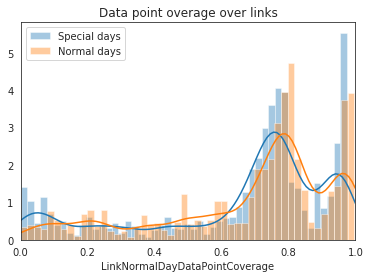

In [42]:
matrix_coverage = pd.read_csv('../data_input/matrix_coverage.csv', sep = ';', parse_dates=True, decimal=',')
fig, ax = plt.subplots(figsize = (6, 4))
ax.set_xlim(0, 1)
sns.distplot(matrix_coverage[matrix_coverage['LinkSpecialDayDataPointCoverage'] > 0]['LinkSpecialDayDataPointCoverage'], bins = 50, label = 'Special days')
sns.distplot(matrix_coverage[matrix_coverage['LinkNormalDayDataPointCoverage'] > 0]['LinkNormalDayDataPointCoverage'], bins = 50, label = 'Normal days')
ax.set_title('Data point overage over links')
ax.legend()

In [43]:
daytype_components = pd.read_csv('../output/reference-link-embeddings.csv', index_col=0)

In [44]:
with open('../output/matrix_imputed.pickle', 'rb') as f:
    matrix_imputed_pelt = pickle.load(f)

In [45]:
change_point_stats = pd.DataFrame([{k: x[k] for k in x.keys() if k not in ['imputed', 'change_points']} for x in matrix_imputed_pelt.values()]).set_index('link_ref')

In [46]:
change_point_stats['change_point_count'].value_counts().sort_index()

1     78
2    418
3    384
4    277
5    186
6     79
7     41
8     17
9      6
Name: change_point_count, dtype: int64

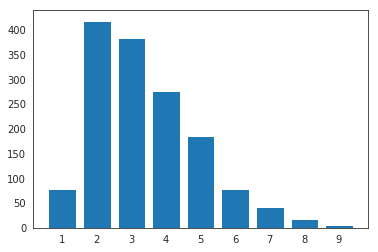

In [47]:
fig, ax = plt.subplots(figsize = (6, 4))
hist=change_point_stats['change_point_count'].value_counts().sort_index()
ax.set_xticks(np.arange(hist.max() + 1))
ax.bar(hist.index, hist.values)
fig.savefig('../plots/change_point_hist.pdf', bbox_inches = 'tight')

### Change Points over the years (summed by week)

In [48]:
changepoints_per_date = pd.DataFrame([(y, 1) for x in matrix_imputed_pelt.values() for y in x['imputed'].index[x['change_points'][:-1]]], columns = ['Date', 'ChangePoints']) \
    .groupby('Date')['ChangePoints'].count().sort_index()
changepoints_per_week = changepoints_per_date.reset_index().groupby(pd.Grouper(key='Date', freq='W-MON', label='left')).sum()

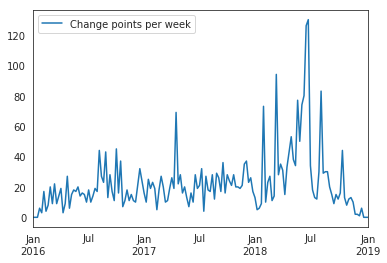

In [49]:
fig, ax = plt.subplots(figsize = (6, 4))
changepoints_per_week.rename({'ChangePoints': 'Change points per week'}, axis = 1).reindex(pd.date_range('2016-01-01', '2019-01-07', freq='W-MON'), fill_value=0).plot(ax = ax)
fig.savefig('../plots/change_point_per_week.pdf', bbox_inches = 'tight')

Zoom un on the spike in summer 2018

In [50]:
import geopandas as gpd
import contextily as ctx

In [51]:
links_geom = gpd.read_file('../data_input/links.geojson')[lambda x: x['ValidToDate'] == '2099-12-31'].set_index('LinkRef').drop(['id'], axis = 1)

NameError: name 'changepoints_focus' is not defined

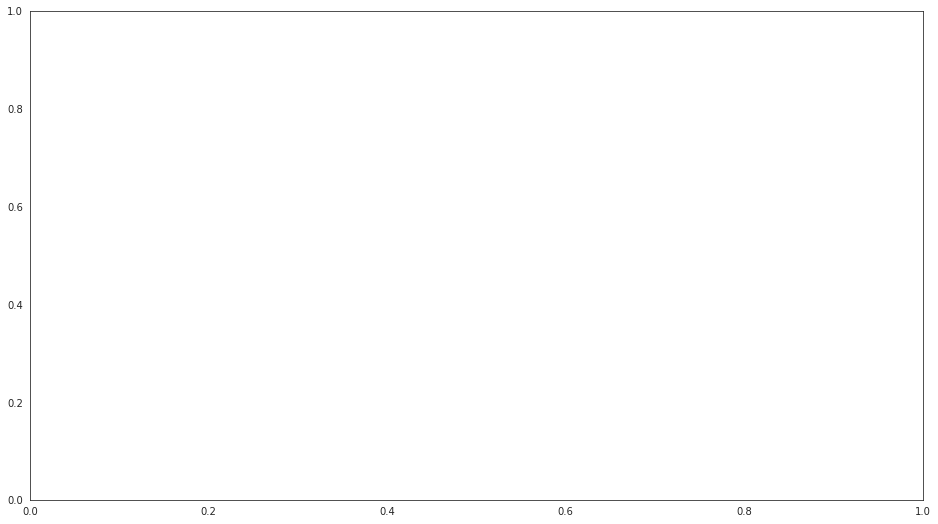

In [52]:
fig, ax = plt.subplots(figsize = (16, 9))
links_geom[lambda x: ~x.index.isin(changepoints_focus['link_ref'])].to_crs(epsg=3857).plot(ax = ax, color = 'blue', linewidth=0.5)
links_geom.loc[changepoints_focus['link_ref']].to_crs(epsg=3857).plot(ax = ax, color = 'red', linewidth=1.5)
#grave[lambda x: (from_date <= x['projekt_slut']) & (x['projekt_start'] <= to_date)].to_crs(epsg=3857).plot(ax = ax, color = 'orange')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4), nrows = 3, sharex=True)
fig.tight_layout()

from ruptures.utils import pairwise
from itertools import cycle

COLOR_CYCLE = ["#4286f4", "#f44174"]
beta = 0.9
change_point_stats_sel = change_point_stats[lambda x: (x['coverage'] > beta) & (x['change_point_count'] > 4)].sample(3, random_state = 10)

for i, (link_ref, row) in enumerate(change_point_stats_sel.iterrows()):
    color_cycle = cycle(COLOR_CYCLE)
    ax[i].plot(matrix_imputed_pelt[link_ref]['imputed'].values, color = 'k', linewidth = .5, linestyle = '-')
    #ax[i].set_title(link_ref)
    #rpt.display(link_travel_time_matrix_imputed_ls[i].values, change_points_ls[i], ax = ax)
    # color each (true) regime
    bkps = [0] + sorted(matrix_imputed_pelt[link_ref]['change_points'])

    for (start, end), col in zip(pairwise(bkps), color_cycle):
        ax[i].axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=.2)

ax[-1].set_xlabel(r'Day, $i$')
fig.text(-0.01, 0.55, 'Link travel time', va='center', rotation='vertical')
fig.tight_layout()
fig.savefig('../plots/non-stationary-examples.pdf', bbox_inches = 'tight')

In [ ]:
fig, ax = plt.subplots(figsize = (6, 4), nrows = 3, sharex=True)
fig.tight_layout()

from ruptures.utils import pairwise
from itertools import cycle

COLOR_CYCLE = ["#4286f4", "#f44174"]
beta = 0.9
change_point_stats_sel = change_point_stats[lambda x: (x['coverage'] > beta) & (x['change_point_count'] == 1)].sample(3, random_state = 10)

for i, (link_ref, row) in enumerate(change_point_stats_sel.iterrows()):
    color_cycle = cycle(COLOR_CYCLE)
    ax[i].plot(matrix_imputed_pelt[link_ref]['imputed'].values, color = 'k', linewidth = .5, linestyle = '-')
    #ax[i].set_title(link_ref)
    #rpt.display(link_travel_time_matrix_imputed_ls[i].values, change_points_ls[i], ax = ax)
    # color each (true) regime
    bkps = [0] + sorted(matrix_imputed_pelt[link_ref]['change_points'])

    for (start, end), col in zip(pairwise(bkps), color_cycle):
        ax[i].axvspan(max(0, start - 0.5), end - 0.5, facecolor=col, alpha=.2)

ax[-1].set_xlabel(r'Day, $i$')
fig.text(-0.01, 0.55, 'Link travel time', va='center', rotation='vertical')
fig.tight_layout()
fig.savefig('../plots/stationary-examples.pdf', bbox_inches = 'tight')

In [53]:
import bokeh
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, ColorBar
from bokeh.models.mappers import LinearColorMapper
from bokeh.tile_providers import get_provider, Vendors

palette = bokeh.palettes.RdBu[9]
#palette = palette[::-1]
color_mapper = LinearColorMapper(palette = palette, low = 1, high = 9,  nan_color = palette[-1])
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color='black',location = (0,0), orientation ='horizontal')
geosource = GeoJSONDataSource(geojson = links_current.to_crs({'init': 'epsg:3857'}).reset_index().to_json())
p = figure(title = 'Link Candidates', plot_height = 600 , plot_width = 1000, toolbar_sticky=False,
           tooltips=[
               ("CellRef", "@LinkRef"),
               ("Change Points", "@change_points")
           ],
           x_axis_type="mercator", y_axis_type="mercator")
#Makes it so there are no gird lines
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None
p.add_tile(get_provider(Vendors.CARTODBPOSITRON))
p.multi_line('xs','ys', source = geosource, line_color = {'field': 'change_points', 'transform' : color_mapper}, line_width = 2, line_alpha = .5)
output_notebook()
show(p)

Loading BokehJS ...

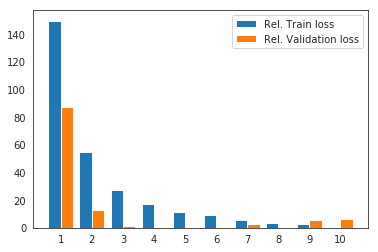

In [54]:
loss_trials = pd.DataFrame([
    [1, 1616.9, 1087.6],
    [2, 1522.2, 1013.6],
    [3, 1494.7, 1001.6],
    [4, 1484.0, 1001.3],
    [5, 1478.3, 1000.7],
    [6, 1476.1, 1000.4],
    [7, 1472.5, 1003.2],
    [8, 1470.8, 1000.8],
    [9, 1470.0, 1006.2],
    [10, 1467.0, 1006.5]
], columns = ['embeddings_dim', 'loss', 'val_loss'])

fig, ax = plt.subplots(figsize = (6, 4))
ax.set_xticks(np.arange(loss_trials['embeddings_dim'].max() + 1))
ax.bar(loss_trials['embeddings_dim'].values - .2, loss_trials['loss'].values - loss_trials['loss'].min(), width = .4, label = 'Rel. Train loss')
ax.bar(loss_trials['embeddings_dim'].values + .2, loss_trials['val_loss'].values - loss_trials['val_loss'].min(), width = .4, label = 'Rel. Validation loss')
ax.legend()
fig.savefig('../plots/embeddings_dim.pdf', bbox_inches = 'tight')

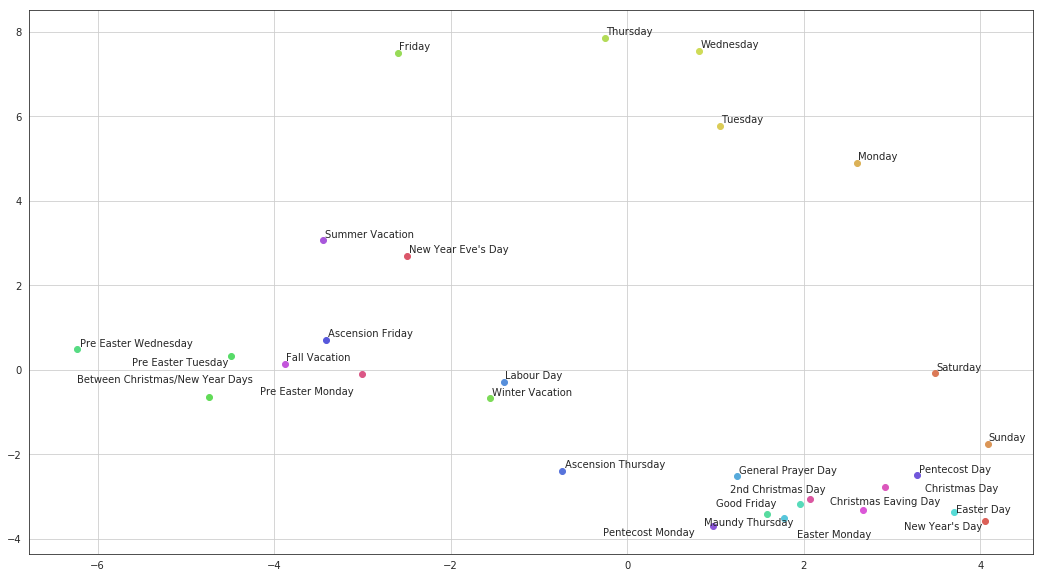

In [55]:
from sklearn import manifold

def plot_mds(ax, mds, labels):
    from adjustText import adjust_text
    pal = sns.color_palette("hls", len(labels))
    texts = []
    for i, l in enumerate(labels):
        ax.scatter(mds[i, 0], mds[i, 1], color = pal[i], label = l)
        text = ax.text(mds[i, 0], mds[i, 1], l, ha='center', va='center')
        texts.append(text)
    adjust_text(texts)

components = pd.read_csv('../output/reference-link-embeddings.csv', index_col = 0)

fig, ax = plt.subplots(figsize = (18, 10))
mds = manifold.MDS()
components_mds = mds.fit_transform(components.values)
ax.grid()
plot_mds(ax, components_mds, components.index)
fig.savefig('../plots/embeddings_mds.pdf', bbox_inches = 'tight')

In [56]:
mds.stress_

127.02410134842765

In [57]:
link_ref = '1417:27686'
group = 'embeddings'
times = ['20190408', '20190415']
models = ['baseline_nn', 'day_type_embeddings']

In [58]:
link_ref = '1417:27686' #'1417:27686'
link_ref_slug = link_ref.replace(':', '-')    

test = pd.DataFrame()

for time in times:
    time_slug = time
    for model in models:
        output_directory = f'../output/{model}/{group}/{link_ref_slug}'
        test_ = pd.read_csv(f'{output_directory}/test_{time_slug}.csv', index_col = 0, parse_dates=True)
        if not np.all(test_.index.isin(test.index)):
            test = test.reindex(test.index.append(test_.index.drop_duplicates()))
            test.loc[test_.index, 'link_travel_time_exp'] = test_['link_travel_time_exp']
        test.loc[test_.index, model] = test_[model]

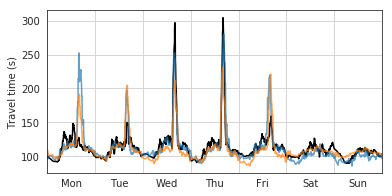

In [59]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.set_ylabel('Travel time (s)')
ax.plot(test[:pd.to_datetime(times[1])]['link_travel_time_exp'], color = 'black')
ax.plot(test[:pd.to_datetime(times[1])]['baseline_nn'], color = 'C0', alpha=0.7)
ax.plot(test[:pd.to_datetime(times[1])]['day_type_embeddings'], color = 'C1', alpha=0.7)
ax.set_xticks(pd.date_range(pd.to_datetime(times[0]), pd.to_datetime(times[1])))
ax.set_xticks(pd.date_range(pd.to_datetime(times[0]), pd.to_datetime(times[1])) + pd.to_timedelta('12H'), minor=True)
ax.set_xticklabels([])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], minor = True)
ax.set_xlim((pd.to_datetime(times[0]), pd.to_datetime(times[0]) + pd.to_timedelta('1W')))
ax.grid()
fig.savefig('../plots/prediction_control.pdf', bbox_inches = 'tight')

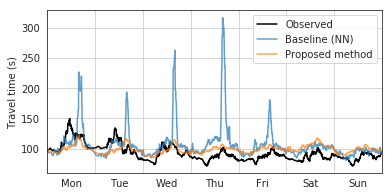

In [64]:
fig, ax = plt.subplots(figsize = (6, 3))
ax.set_ylabel('Travel time (s)')
ax.plot(test[pd.to_datetime(times[1]):]['link_travel_time_exp'], color = 'black', label = 'Observed')
ax.plot(test[pd.to_datetime(times[1]):]['baseline_nn'], color = 'C0', alpha=0.7, label = 'Baseline (NN)')
ax.plot(test[pd.to_datetime(times[1]):]['day_type_embeddings'], color = 'C1', alpha=0.7, label = 'Proposed method')
ax.set_xticks(pd.date_range(pd.to_datetime(times[1]), pd.to_datetime(times[1]) + pd.to_timedelta('1W')))
ax.set_xticks(pd.date_range(pd.to_datetime(times[1]), pd.to_datetime(times[1]) + pd.to_timedelta('1W')) + pd.to_timedelta('12H'), minor=True)
ax.set_xticklabels([])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], minor = True)
ax.set_xlim((pd.to_datetime(times[1]), pd.to_datetime(times[1]) + pd.to_timedelta('1W')))
ax.legend()
ax.grid()
fig.savefig('../plots/prediction_test.pdf', bbox_inches = 'tight')

## Tables

In [61]:
calendar = pd.read_csv('../data_input/calendar.csv', index_col=0)

In [62]:
tab = calendar['2018-12-29':][['Day', 'DayType']].head(6)
tab['Special Condition'] = tab['Day'] != tab['DayType'] 
tab['One hot Encoding'] = ['[1, 0, 0, 0, $\ldots$, 0]','[1, 0, 0, 0, $\ldots$, 0]','[0, 1, 0, 0, $\ldots$, 0]','[0, 0, 1, 0, $\ldots$, 0]','[0, 0, 0, 1, $\ldots$, 0]','[0, 0, 0, 0, $\ldots$, 1]']

tab = tab.drop('Day', axis = 1)
tab

,DayType,Special Condition,One hot Encoding
2018-12-29,Between Christmas/New Year Days,True,"[1, 0, 0, 0, $\ldots$, 0]"
2018-12-30,Between Christmas/New Year Days,True,"[1, 0, 0, 0, $\ldots$, 0]"
2018-12-31,New Year Eve's Day,True,"[0, 1, 0, 0, $\ldots$, 0]"
2019-01-01,New Year's Day,True,"[0, 0, 1, 0, $\ldots$, 0]"
2019-01-02,Wednesday,False,"[0, 0, 0, 1, $\ldots$, 0]"
2019-01-03,Thursday,False,"[0, 0, 0, 0, $\ldots$, 1]"


In [63]:
print(tab.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
{} &                          DayType &  Special Condition &           One hot Encoding \\
\midrule
2018-12-29 &  Between Christmas/New Year Days &               True &  [1, 0, 0, 0, $\ldots$, 0] \\
2018-12-30 &  Between Christmas/New Year Days &               True &  [1, 0, 0, 0, $\ldots$, 0] \\
2018-12-31 &               New Year Eve's Day &               True &  [0, 1, 0, 0, $\ldots$, 0] \\
2019-01-01 &                   New Year's Day &               True &  [0, 0, 1, 0, $\ldots$, 0] \\
2019-01-02 &                        Wednesday &              False &  [0, 0, 0, 1, $\ldots$, 0] \\
2019-01-03 &                         Thursday &              False &  [0, 0, 0, 0, $\ldots$, 1] \\
\bottomrule
\end{tabular}

